In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm

In [70]:
v10_cb = pd.read_csv("v10_cb.csv")
v10_p4 = pd.read_csv("v10_p4.csv")

v10_cb["timestamp"]= v10_cb["timestamp"].apply(lambda x: datetime.fromtimestamp(x/1000))
v10_p4["timestamp"]= v10_p4["timestamp"].apply(lambda x: datetime.fromtimestamp(x/1000))

v10_cb["timestamp"]= v10_cb["timestamp"].apply(lambda x: x - v10_cb["timestamp"][0])
v10_p4["timestamp"]= v10_p4["timestamp"].apply(lambda x: x - v10_p4["timestamp"][0])

v10_cb["timestamp"] = v10_cb["timestamp"].dt.seconds + v10_cb["timestamp"].dt.microseconds/10e6
v10_p4["timestamp"] = v10_p4["timestamp"].dt.seconds + v10_p4["timestamp"].dt.microseconds/10e6

In [71]:
dt_cb = v10_cb["timestamp"]
dt_p4 = v10_p4["timestamp"]

cb = v10_cb["val"]
p4 = v10_p4["val"]

In [72]:
np.min(cb)

0.280737

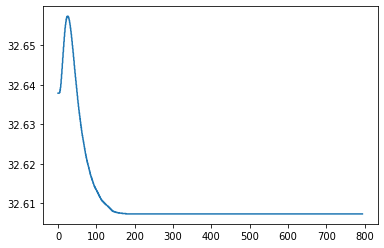

In [73]:
plt.plot(dt_p4,p4)
plt.show()

In [86]:
epochs = 20000
optimizer = tf.keras.optimizers.SGD(learning_rate=10e-2, momentum=0.9)
# t0 = tf.Variable(tf.random.uniform((1,),minval=-100, maxval=100, name='t0'))
# t1 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t1'))
# t2 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t2'))

t0 = tf.Variable(0.0, name='t0')
t1 = tf.Variable(1.0, name='t1')
t2 = tf.Variable(2.0, name='t2')

loss_metric = tf.keras.metrics.Mean()

def loss_compute(y_true, y_pred):
    return tf.square(y_true - y_pred)

# print(t0)
# print(t1)
# print(t2)
# print(" ")

for epoch in range(epochs):
    # pbar = tqdm(range(len(p4)))
    loss = 0
    # for batch_id in pbar:
    time = tf.constant(dt_p4,dtype=tf.float32)
    y = tf.constant(p4,dtype = tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        # y = A+B*(1+C*e**(-t/D)+E*e**(-t/F))
        e1 = np.exp(-time/tf.abs(t1))
        e2 = np.exp(-time/tf.abs(t2))
        c1 = tf.divide(tf.subtract(t0,t1),tf.subtract(t1,t2))
        c2 = tf.divide(tf.subtract(t0,t2),tf.subtract(t2,t1))
        h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
        h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
        h = 1 + h1 + h2
        y_ = p4[0]+tf.multiply(p4[-1:]-p4[0],h)
        loss1 = loss_compute(y, y_)
        loss = tf.reduce_sum(loss1)
        # print(e1," , ", e2," , ",c1," , ",c2," , ",h1," , ",h2)
        # loss_metric(loss)
        # pbar.set_description('Training Loss: %.3f' % 
        #                         loss_metric.result().numpy())

    gradients = tape.gradient(loss,[t0,t1, t2])
    optimizer.apply_gradients(zip(gradients, [t0,t1,t2]))
    # print(gradients)
    # print(" ")
    # print(t0)
    # print(t1)
    # print(t2)
    # print(" ")

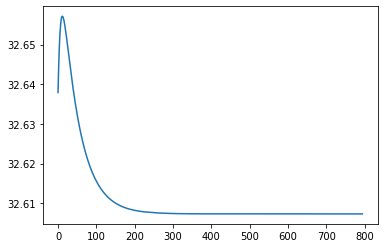

In [87]:
e1 = np.exp(-dt_p4/tf.abs(t1))
e2 = np.exp(-dt_p4/tf.abs(t2))
c1 = tf.divide(tf.subtract(t0,tf.abs(t1)),tf.subtract(tf.abs(t1),tf.abs(t2)))
c2 = tf.divide(tf.subtract(t0,tf.abs(t2)),tf.subtract(tf.abs(t2),tf.abs(t1)))
h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
h = 1 + h1 + h2
y_ = p4[0]+tf.multiply(p4[-1:]-p4[0],h)
plt.plot(dt_p4,y_)
plt.show()

In [88]:
print(t0)
print(t1)
print(t2)
print(loss)

<tf.Variable 't0:0' shape=() dtype=float32, numpy=-49.135975>
<tf.Variable 't1:0' shape=() dtype=float32, numpy=7.1438093>
<tf.Variable 't2:0' shape=() dtype=float32, numpy=44.99074>
tf.Tensor(0.045843836, shape=(), dtype=float32)


<tf.Variable 't0:0' shape=() dtype=float32, numpy=-51.70147>

<tf.Variable 't1:0' shape=() dtype=float32, numpy=43.729183>

<tf.Variable 't2:0' shape=() dtype=float32, numpy=10.972501>

tf.Tensor(0.029994767, shape=(), dtype=float32)

In [89]:
t=tf.Variable(3.0)
# for i in range(len(dt_p4)):
x = tf.constant(dt_p4,dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape:
    y =tf.exp(-x/t)
    a = tf.reduce_sum(y)

print(a)
print(y)
grad = tape.gradient(a,t)
print(grad)

tf.Tensor(32.273415, shape=(), dtype=float32)
tf.Tensor([1.        0.9960412 0.9927928 ... 0.        0.        0.       ], shape=(7226,), dtype=float32)
tf.Tensor(9.016115, shape=(), dtype=float32)
